In [46]:
'''Libraries'''
import numpy as np, torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader, Subset
from laplace import Laplace
import matplotlib.pyplot as plt
import laplace
import pickle

In [ ]:
'''Dataset Loader for Digits dataset'''
np.random.seed(0)
torch.manual_seed(0)

# Data
digits = load_digits()
X, y = digits.data.astype(np.float32), digits.target.astype(np.int64)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

scaler = StandardScaler().fit(Xtr)
Xtr, Xte = scaler.transform(Xtr), scaler.transform(Xte)

Xtr_t = torch.from_numpy(Xtr)
ytr_t = torch.from_numpy(ytr)
Xte_t = torch.from_numpy(Xte)
yte_t = torch.from_numpy(yte)

train_set = TensorDataset(Xtr_t, ytr_t)
print(train_set)
n_train = len(train_set)

Task 1.1
According To Parameter of Model increasing, Does it's spectrum changes?

In [ ]:
def count_parameters(model, only_trainable=False):
    """
    모델의 파라미터 개수를 반환합니다.
    only_trainable=True이면 requires_grad=True인 파라미터만 셉니다.
    """
    params = (p for p in model.parameters() if (not only_trainable) or p.requires_grad)
    return sum(p.numel() for p in params)

def get_models():
    models = []

    # 1. 가장 단순한 모델
    models.append(nn.Linear(64, 10))

    # 2. 파라미터 2배: Linear + Linear
    models.append(nn.Sequential(
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    ))

    # 3. 더 깊게: Linear + Linear + Linear
    models.append(nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    ))

    # 4. 더 깊고 넓게
    models.append(nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 5. BatchNorm 추가
    models.append(nn.Sequential(
        nn.Linear(64, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ))

    # 6. Dropout 추가
    models.append(nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 7. 더 깊게, 더 넓게
    models.append(nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 8. 더 많은 레이어와 BatchNorm, Dropout
    models.append(nn.Sequential(
        nn.Linear(64, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 9. 더 깊고 넓게, 활성화 다양화
    models.append(nn.Sequential(
        nn.Linear(64, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.Tanh(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 10. 가장 큰 모델
    models.append(nn.Sequential(
        nn.Linear(64, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    return models

def evaluate(loader, model):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in loader:
                outputs = model(inputs)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        return correct / total

def cumulative_explained_ratio(val, alpha=0.9):
    """
    val: list or np.array of eigenvalues (can be positive/negative)
    alpha: target cumulative proportion (e.g., 0.9)
    
    Returns:
        ratio (float): index/p where cumulative sum first exceeds alpha
        idx (int): the actual index achieving it
    """
    val = np.array(val, dtype=float)
    # 음수 값은 curvature 설명에 기여하지 않도록 제거 (필요시 옵션화 가능)
    val = np.maximum(val, 0)
    
    if np.sum(val) == 0:
        return 0.0, 0

    sorted_vals = np.sort(val)[::-1]  # 내림차순 정렬
    cumvals = np.cumsum(sorted_vals)
    total = cumvals[-1]
    threshold = alpha * total

    idx = np.searchsorted(cumvals, threshold)
    ratio = (idx + 1) / len(val)
    return ratio, idx + 1

In [54]:
models = get_models()

Datas = []

for i in range(len(models)) :
    model = models[i] 
    print("Training model with {} parameters".format(count_parameters(model)))
    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

    # create evaluation loaders (uses existing Xte_t, yte_t, train_set)
    test_set = TensorDataset(Xte_t, yte_t)
    test_loader = DataLoader(test_set, batch_size=256, shuffle=False)
    train_eval_loader = DataLoader(train_set, batch_size=256, shuffle=False)

    # Run training with real-time accuracy logging
    n_epochs_monitor = 30  # number of epochs to run/continue training
    for epoch in range(n_epochs_monitor):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_acc = evaluate(train_eval_loader, model)
        test_acc = evaluate(test_loader, model)
        print(f"Epoch {epoch+1}/{n_epochs_monitor} - loss: {avg_loss:.4f} - train_acc: {train_acc:.4f} - test_acc: {test_acc:.4f}")

    la = Laplace(model, 'classification',
            subset_of_weights='all',
            hessian_structure='diag',
          )
    la.fit(train_loader)
    val = la.H.numpy()
    Datas.append(val)

Training model with 650 parameters
Epoch 1/30 - loss: 1.1704 - train_acc: 0.9161 - test_acc: 0.9022
Epoch 2/30 - loss: 0.3727 - train_acc: 0.9480 - test_acc: 0.9267
Epoch 3/30 - loss: 0.2682 - train_acc: 0.9547 - test_acc: 0.9333
Epoch 4/30 - loss: 0.2228 - train_acc: 0.9614 - test_acc: 0.9400
Epoch 5/30 - loss: 0.1957 - train_acc: 0.9673 - test_acc: 0.9467
Epoch 6/30 - loss: 0.1773 - train_acc: 0.9681 - test_acc: 0.9467
Epoch 7/30 - loss: 0.1793 - train_acc: 0.9718 - test_acc: 0.9511
Epoch 8/30 - loss: 0.1478 - train_acc: 0.9740 - test_acc: 0.9578
Epoch 9/30 - loss: 0.1404 - train_acc: 0.9770 - test_acc: 0.9600
Epoch 10/30 - loss: 0.1294 - train_acc: 0.9777 - test_acc: 0.9622
Epoch 11/30 - loss: 0.1222 - train_acc: 0.9777 - test_acc: 0.9622
Epoch 12/30 - loss: 0.1168 - train_acc: 0.9785 - test_acc: 0.9622
Epoch 13/30 - loss: 0.1112 - train_acc: 0.9807 - test_acc: 0.9622
Epoch 14/30 - loss: 0.1065 - train_acc: 0.9800 - test_acc: 0.9622
Epoch 15/30 - loss: 0.1024 - train_acc: 0.9822 - t

In [ ]:
n_repeats = 10
alpha = 0.9
results = {}

for repeat in range(n_repeats):
    print(f"\n=== Repetition {repeat+1}/{n_repeats} ===")
    
    # 💡 매 반복마다 fresh initialization
    models = get_models()

    for model in models:
        n_params = count_parameters(model)
        x_val = np.log(n_params)

        print(f"\nTraining model with {n_params} parameters (repeat {repeat+1})")

        torch.manual_seed(repeat)
        np.random.seed(repeat)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
        test_loader = DataLoader(TensorDataset(Xte_t, yte_t), batch_size=256, shuffle=False)
        train_eval_loader = DataLoader(train_set, batch_size=256, shuffle=False)

        n_epochs_monitor = 30
        for epoch in range(n_epochs_monitor):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

        # after training:
        la = Laplace(model, 'classification', subset_of_weights='all', hessian_structure='diag')
        la.fit(train_loader)
        val = la.H.cpu().numpy()

        ratio, idx = cumulative_explained_ratio(val, alpha=alpha)

        # 💾 ratio + full eigenvalues 둘 다 저장
        results.setdefault(x_val, []).append({
            'ratio': ratio,
            'eigenvalues': val
        })

with open("results_curvature_concentration.pkl", "wb") as f:
    pickle.dump(results, f)


=== Repetition 1/10 ===

Training model with 650 parameters (repeat 1)

Training model with 4810 parameters (repeat 1)

Training model with 17226 parameters (repeat 1)

Training model with 26122 parameters (repeat 1)

Training model with 44170 parameters (repeat 1)

Training model with 50826 parameters (repeat 1)

Training model with 116618 parameters (repeat 1)


Text(0.5, 1.0, 'Model Complexity vs. Curvature Concentration')

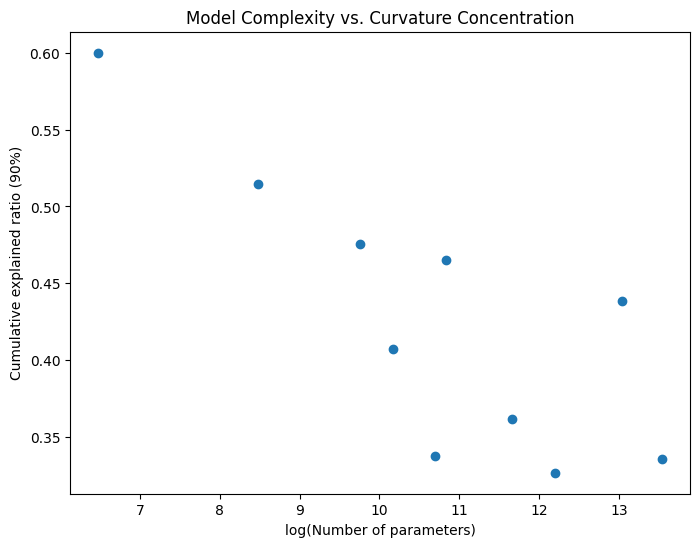

In [79]:
Datas_drawing = []
for i, val in enumerate(Datas):
    y = cumulative_explained_ratio(val, alpha=0.9)
    x = np.log(len(val))
    Datas_drawing.append((x, y[0]))
plt.figure(figsize=(8,6))
plt.scatter(*zip(*Datas_drawing))
plt.xlabel("log(Number of parameters)")
plt.ylabel("Cumulative explained ratio (90%)")
plt.title("Model Complexity vs. Curvature Concentration")

AttributeError: Rectangle.set() got an unexpected keyword argument 'num_bins'

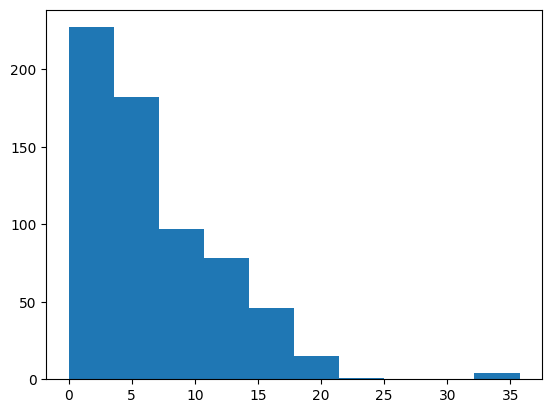

In [ ]:
la = Laplace(model, 'classification',
            subset_of_weights='all',
            hessian_structure='diag',
          )
la.fit(train_loader)
val = la.H.numpy()
plt.hist(val)